In [13]:
# ALL PLOTS WERE DONE ON matplotlib==3.10.0
# Tensorflow has compatibility issues with 3.10.0, so now in requirements.txt there is 3.9.0 version

In [14]:
from headers import *
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
from utils.custom_train_test_split import custom_train_test_split
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, make_scorer, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from joblib import dump, load
from IPython.display import Markdown, display
from math import sqrt
import json

Obserwacja:
train test split per firma daje dużo trudniejsze zadanie dla modeli.
Jednak dane w obrębie 1 firmy muszą być od siebie stosunkowo nieźle zależne. W szczególności dla wartości cutoff > 0.1, 
gdzie teraz SVM i DTree raczej robią overfit niż faktycznie trafiają.
Wcześniej było inaczej.

Możliwa jeszcze zabawa z (krzywą roc i predict_proba) lub z wagami, by spróbować dostosować SVM do większych wartości cutoff. 
Obecnie duży cutoff powoduje zwracanie 0-3 wartości True

In [15]:
cutoffs = [0.0, 0.01, 0.02, 0.03, 0.05, 0.07, 0.10, 0.15, 0.20, 0.25, 0.35]

trainDf, testDf = custom_train_test_split(['../data/combined_inner_ticker.csv', '../data/extra-data/combined_inner_ticker.csv'])
X_train = trainDf[ratioKeys + relativeRatioKeys]
X_test = testDf[ratioKeys + relativeRatioKeys]

# TODO: Czy dobór cutoff jest błędem na zbiorze testowym?? Czy nie powinienem mieć walidacyjnego?

resultsToPlot = {}

for yLabel in yAlpha:
    if yLabel not in resultsToPlot:
        resultsToPlot[yLabel] = {}
    for cutoff in cutoffs:
        y_train = np.where(trainDf[yLabel] <= cutoff, 0, 1)
        y_test = np.where(testDf[yLabel] <= cutoff, 0, 1)
        pipelines = {
            'tree': Pipeline([
                ('scaler', StandardScaler()),
                ('tree', DecisionTreeClassifier(class_weight='balanced'))
            ]),
            'svc': Pipeline([
                ('scaler', StandardScaler()),
                ('svc', LinearSVC(class_weight='balanced'))
            ])
        }
        params = [
            {
                'tree__criterion': ["gini", "entropy", "log_loss"],
            },
            {
                'svc__C': [0.1, 0.5, 1.0, 5.0, 10.0],
                'svc__penalty': ['l1', 'l2']
            }
        ]
        for (key, pipeline), param_grid in zip(pipelines.items(), params):
            grid = GridSearchCV(pipeline,
                        param_grid,
                        cv=StratifiedKFold(3, shuffle=True, random_state=3),
                        verbose=1,
                        refit=True,
                        n_jobs=-1,
                        # scoring='f1',
                        )
            grid.fit(X_train, y_train)
            y_pred = grid.predict(X_test)
            wholeTestData = testDf.loc[testDf.index.intersection(X_test.index)]
            
            xTaken = X_test[y_pred == 1]
            xTrue = X_test[y_test == 1]
            
            takenData = testDf.loc[testDf.index.intersection(xTaken.index)]
            trueData = testDf.loc[testDf.index.intersection(xTrue.index)]
            
            prc = round(takenData.loc[:, yLabel].count() / wholeTestData.loc[:, yLabel].count(), 4) * 100
            print(f'MODEL {key}')
            print(f'For {yLabel}, yCutoff = {cutoff}, taken used - {takenData.loc[:, yLabel].count()} is {prc}%')
            print(f'Mean was {round(takenData.loc[:, yLabel].mean() * 100, 2)}%, median was {round(takenData.loc[:, yLabel].median()*100, 2)}%')
            print(f'% of True in dataset {round(len(y_test[y_test==1]) / len(y_test) * 100, 2)}% resulted in {round(trueData.loc[:, yLabel].mean() * 100, 2)}% and median {round(trueData.loc[:, yLabel].median() * 100,2)}%')
            print('-----------')
            
            if key not in resultsToPlot[yLabel]:
                resultsToPlot[yLabel][key] = []
            resultsToPlot[yLabel][key].append({
                'mean': takenData.loc[:, yLabel].mean(),
                'median': takenData.loc[:, yLabel].median(),
                'taken': takenData.loc[:, yLabel].count()
            })

Fitting 3 folds for each of 3 candidates, totalling 9 fits
MODEL tree
For alpha1Year, yCutoff = 0.0, taken used - 3802 is 49.58%
Mean was 3.4%, median was 0.3%
% of True in dataset 49.39% resulted in 28.51% and median 18.02%
-----------
Fitting 3 folds for each of 10 candidates, totalling 30 fits
MODEL svc
For alpha1Year, yCutoff = 0.0, taken used - 3760 is 49.03%
Mean was 6.61%, median was 0.89%
% of True in dataset 49.39% resulted in 28.51% and median 18.02%
-----------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
MODEL tree
For alpha1Year, yCutoff = 0.01, taken used - 3781 is 49.3%
Mean was 5.26%, median was 1.02%
% of True in dataset 47.61% resulted in 29.56% and median 18.85%
-----------
Fitting 3 folds for each of 10 candidates, totalling 30 fits
MODEL svc
For alpha1Year, yCutoff = 0.01, taken used - 3761 is 49.04%
Mean was 6.56%, median was 0.86%
% of True in dataset 47.61% resulted in 29.56% and median 18.85%
-----------
Fitting 3 folds for each of 3 candidates, t

NO class weights

In [26]:
cutoffs = [0.0, 0.01, 0.02, 0.03, 0.05, 0.07, 0.10, 0.15, 0.20, 0.25, 0.35]

trainDf, testDf = custom_train_test_split(['../data/combined_inner_ticker.csv', '../data/extra-data/combined_inner_ticker.csv'])
X_train = trainDf[ratioKeys + relativeRatioKeys]
X_test = testDf[ratioKeys + relativeRatioKeys]

# TODO: Czy dobór cutoff jest błędem na zbiorze testowym?? Czy nie powinienem mieć walidacyjnego?

resultsToPlotNoWeights = {}

for yLabel in yAlpha:
    if yLabel not in resultsToPlotNoWeights:
        resultsToPlotNoWeights[yLabel] = {}
    for cutoff in cutoffs:
        y_train = np.where(trainDf[yLabel] <= cutoff, 0, 1)
        y_test = np.where(testDf[yLabel] <= cutoff, 0, 1)
        pipelines = {
            'tree': Pipeline([
                ('scaler', StandardScaler()),
                ('tree', DecisionTreeClassifier())
            ]),
            'svc': Pipeline([
                ('scaler', StandardScaler()),
                ('svc', LinearSVC())
            ])
        }
        params = [
            {
                'tree__criterion': ["gini", "entropy", "log_loss"],
            },
            {
                'svc__C': [0.1, 0.5, 1.0, 5.0, 10.0],
                'svc__penalty': ['l1', 'l2']
            }
        ]
        for (key, pipeline), param_grid in zip(pipelines.items(), params):
            grid = GridSearchCV(pipeline,
                        param_grid,
                        cv=StratifiedKFold(3, shuffle=True, random_state=3),
                        verbose=1,
                        refit=True,
                        n_jobs=-1,
                        # scoring='f1',
                        )
            grid.fit(X_train, y_train)
            y_pred = grid.predict(X_test)
            
            wholeTestData = testDf.loc[testDf.index.intersection(X_test.index)]
            
            xTaken = X_test[y_pred == 1]
            xTrue = X_test[y_test == 1]
            
            
            takenData = testDf.loc[testDf.index.intersection(xTaken.index)]
            trueData = testDf.loc[testDf.index.intersection(xTrue.index)]
            
            prc = round(takenData.loc[:, yLabel].count() / wholeTestData.loc[:, yLabel].count(), 4) * 100
            print(f'MODEL {key}')
            print(f'For {yLabel}, yCutoff = {cutoff}, taken used - {takenData.loc[:, yLabel].count()} is {prc}%')
            print(f'Mean was {round(takenData.loc[:, yLabel].mean() * 100, 2)}%, median was {round(takenData.loc[:, yLabel].median()*100, 2)}%')
            

            print(f'% of True in dataset {round(len(y_test[y_test==1]) / len(y_test) * 100, 2)}% resulted in {round(trueData.loc[:, yLabel].mean() * 100, 2)}% and median {round(trueData.loc[:, yLabel].median() * 100,2)}%')
            
            # run pipeline by hand to use decision function
            if key == 'svc':
                model = grid.best_estimator_['svc']
                scaler = grid.best_estimator_['scaler']
                X_scaled = scaler.transform(X_test)
                scores = model.decision_function(X_scaled)
                threshold = np.percentile(scores, 80)
                y_pred_threshold = scores >= threshold
                xTakenThreshold = X_test[y_pred_threshold]
                takenDataThreshold = testDf.loc[testDf.index.intersection(xTakenThreshold.index)]
                print(f'% of True taken with threshold adjustment -  {takenDataThreshold.loc[:, yLabel].count()}')
                print(f'For threshold data - mean was {round(takenDataThreshold.loc[:, yLabel].mean() * 100, 2)}%, median was {round(takenDataThreshold.loc[:, yLabel].median()*100, 2)}%')
            print('-----------------')
            
            if key not in resultsToPlotNoWeights[yLabel]:
                resultsToPlotNoWeights[yLabel][key] = []
            resultsToPlotNoWeights[yLabel][key].append({
                'mean': takenData.loc[:, yLabel].mean(),
                'median': takenData.loc[:, yLabel].median(),
                'taken': takenData.loc[:, yLabel].count()
            })
            if key == 'svc':
                if 'svcThreshold' not in resultsToPlotNoWeights[yLabel]:
                    resultsToPlotNoWeights[yLabel]['svcThreshold'] = []
                resultsToPlotNoWeights[yLabel]['svcThreshold'].append({
                    'mean': takenDataThreshold.loc[:, yLabel].mean(),
                    'median': takenDataThreshold.loc[:, yLabel].median(),
                    'taken': takenDataThreshold.loc[:, yLabel].count()
                })

Fitting 3 folds for each of 3 candidates, totalling 9 fits
MODEL tree
For alpha1Year, yCutoff = 0.0, taken used - 3686 is 48.06%
Mean was 3.47%, median was -0.2%
% of True in dataset 49.39% resulted in 28.51% and median 18.02%
-----------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits
MODEL svc
For alpha1Year, yCutoff = 0.0, taken used - 2035 is 26.540000000000003%
Mean was 8.84%, median was 1.54%
% of True in dataset 49.39% resulted in 28.51% and median 18.02%
% of True taken with threshold adjustment -  1534
For threshold data - mean was 9.74%, median was 2.12%
-----------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
MODEL tree
For alpha1Year, yCutoff = 0.01, taken used - 3631 is 47.349999999999994%
Mean was 4.42%, median was 0.57%
% of True in dataset 47.61% resulted in 29.56% and median 18.85%
-----------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits
MODEL svc
For alpha1Year, yCutoff = 0.01, taken used - 963 is 12.5599999

In [17]:
 # DONE: Adjust class_weight to favor the positive class
# TODO: Manually adjust the decision threshold
# probs = model.predict_proba(X_test)[:, 1] - decision_function works. Problems with predict proba
# preds = (probs > 0.3).astype(int)  # Lower threshold from default 0.5
resultsToPlot
with open('./toPlot.json', 'w') as f:
    json.dump(resultsToPlot, f, default=float)

In [27]:
def drawFrom1results(toPlot, yLabel, title='', keys=['svc', 'tree',]):
    axes = []
    if len(keys) == 2:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4))
        axes = [ax1, ax2]
    else:
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 4))
        axes = [ax1, ax2, ax3]
        
    for i, key in enumerate(keys):
        axes[i].plot(x, [d['mean'] for d in toPlot[key]], color='red', label='mean')
        axes[i].plot(x, [d['median'] for d in toPlot[key]], color='green', label='median')
        
        axes[i].legend(loc='upper left')
        axes[i].grid(True)
        
        ax1b = axes[i].twinx()
        ax1b.plot(x, [d['taken'] for d in toPlot[key]], color='blue', label='taken')
        ax1b.legend(loc='upper right')
        ax1b.set_yscale('log')
        axes[i].set_xscale('log')
    
        plt.title(f'Cutoff influence for {yLabel} {key} {title}')
    
    # # TODO: XD
    # toPlot = resultsToPlot[yLabel]['tree']
    # 
    # ax2.plot(x, [d['mean'] for d in toPlot], color='red', label='mean')
    # ax2.plot(x, [d['median'] for d in toPlot], color='green', label='median')
    # 
    # ax2.legend(loc='upper left')
    # ax2.grid(True)
    # 
    # ax2b = ax2.twinx()
    # ax2b.plot(x, [d['taken'] for d in toPlot], color='blue', label='taken')
    # ax2b.legend(loc='upper right')
    # ax2b.set_yscale('log')
    # plt.title(f'Cutoff influence for {yLabel} TREE {title}')


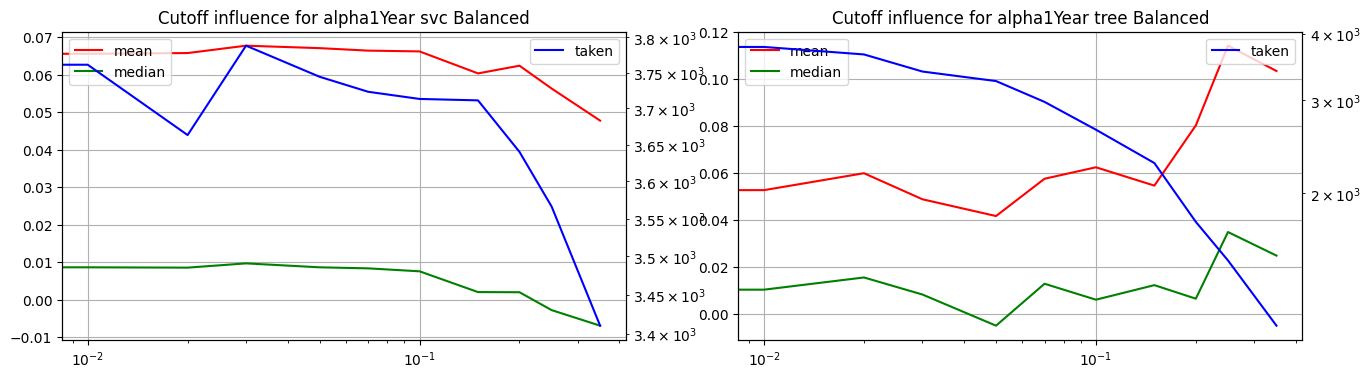

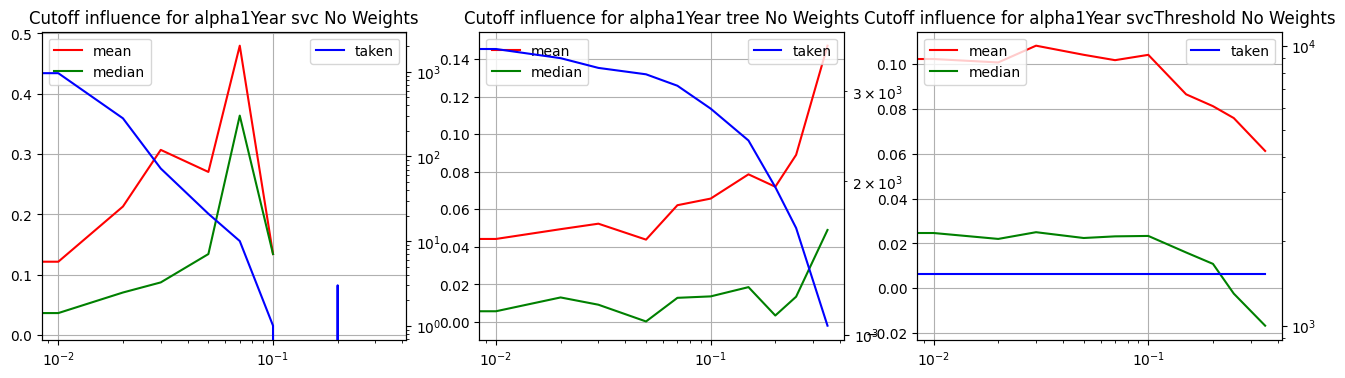

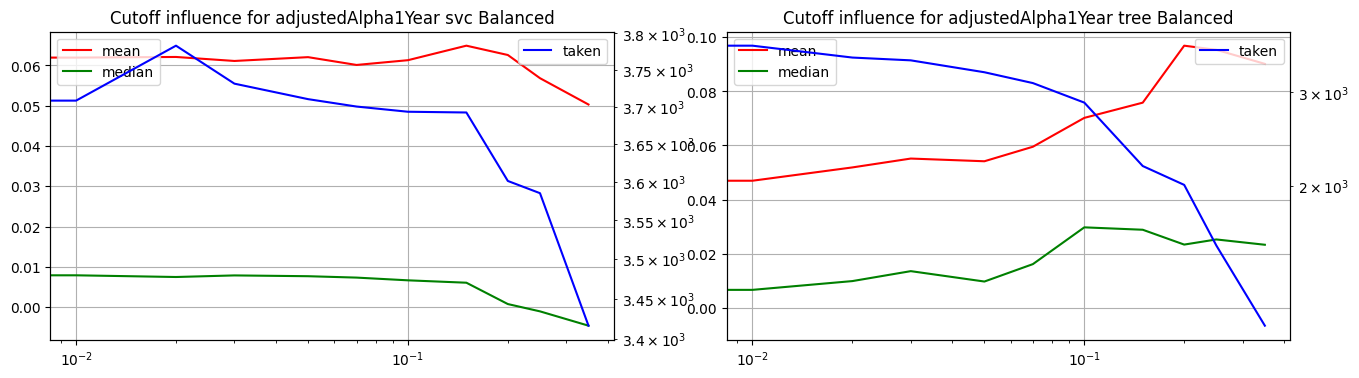

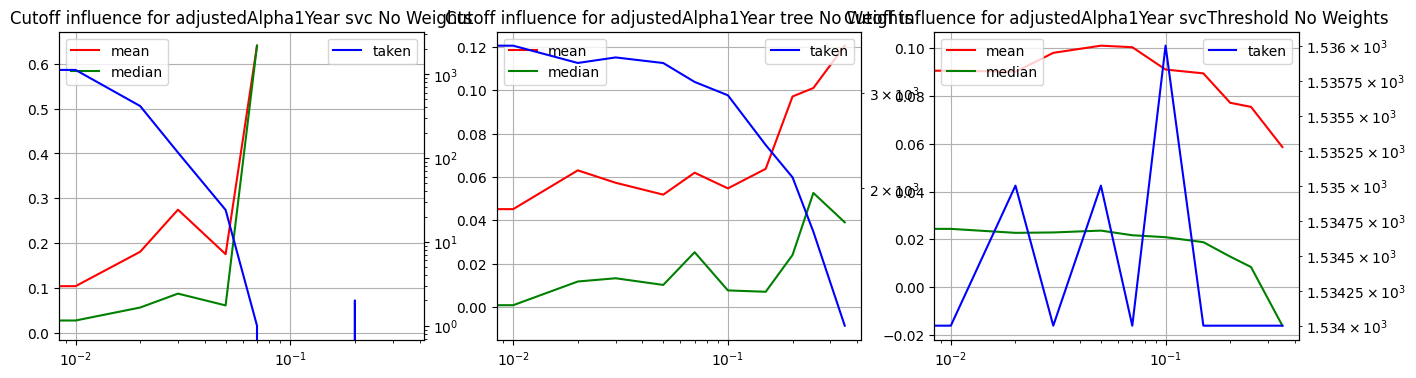

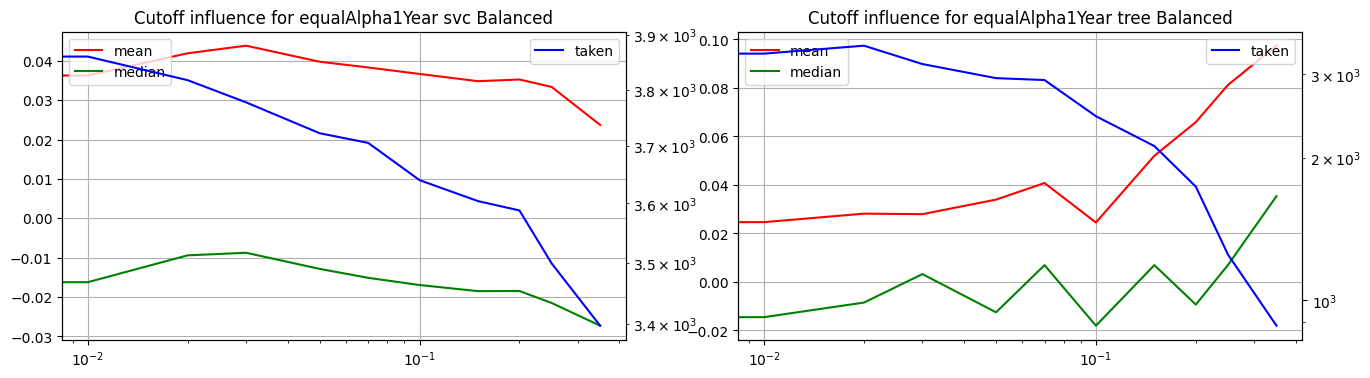

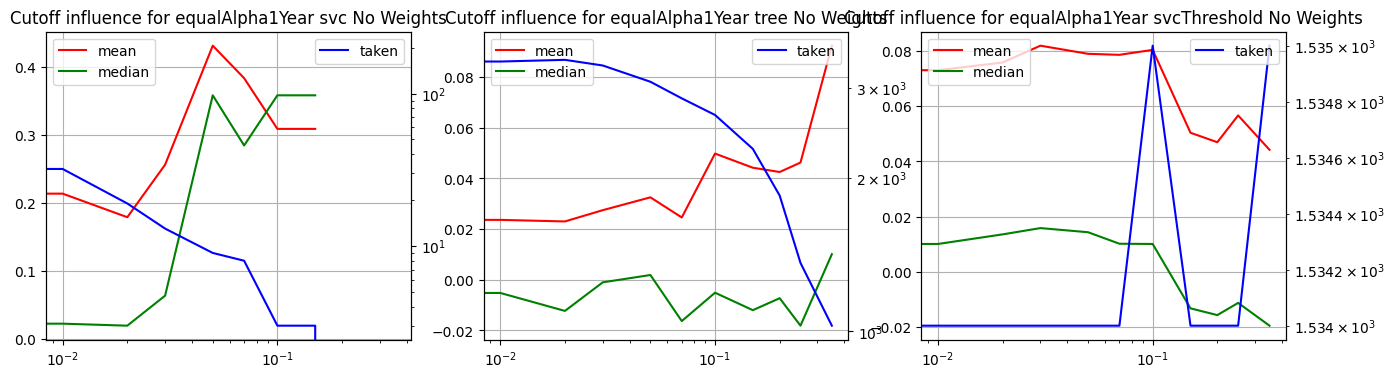

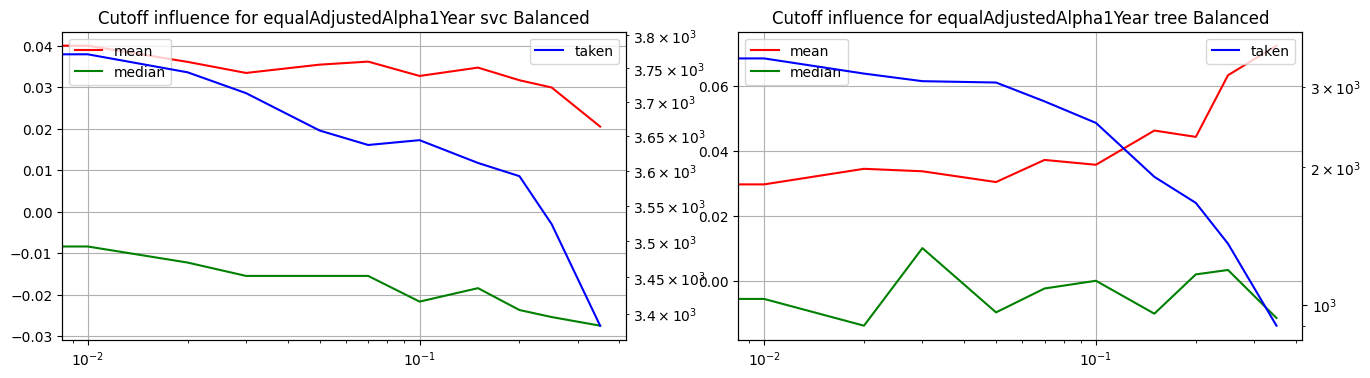

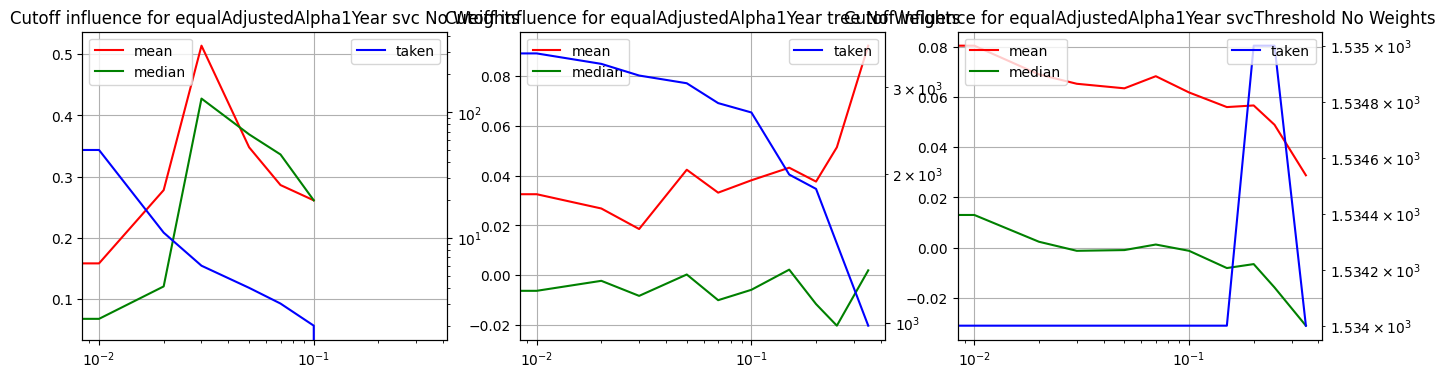

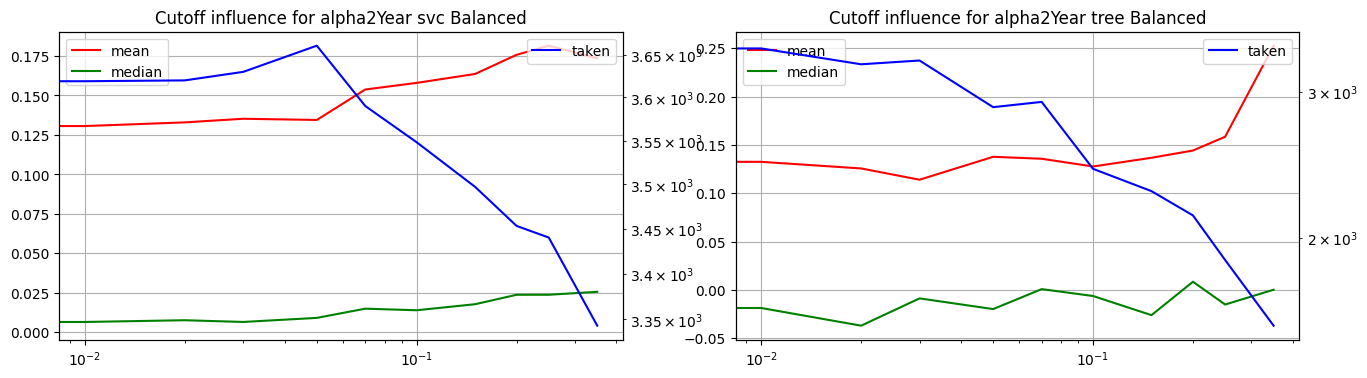

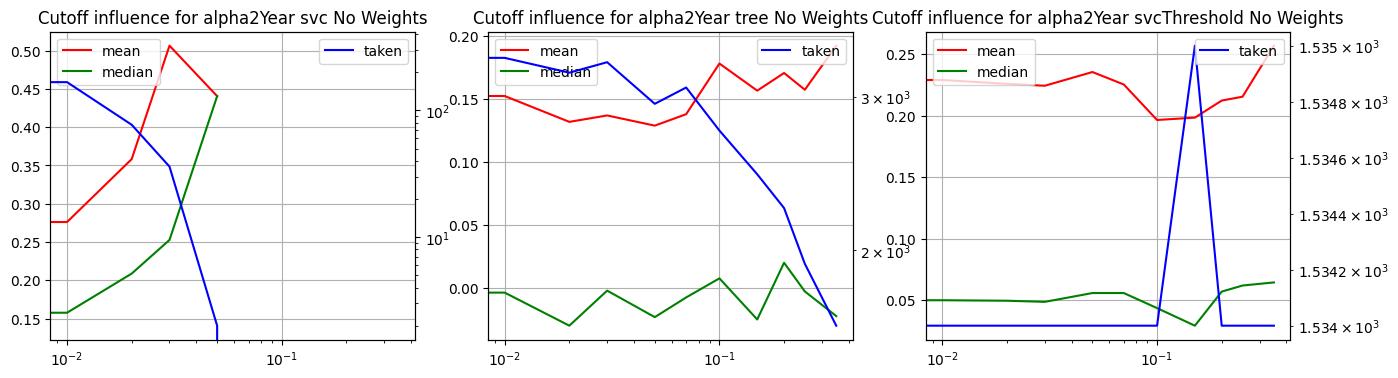

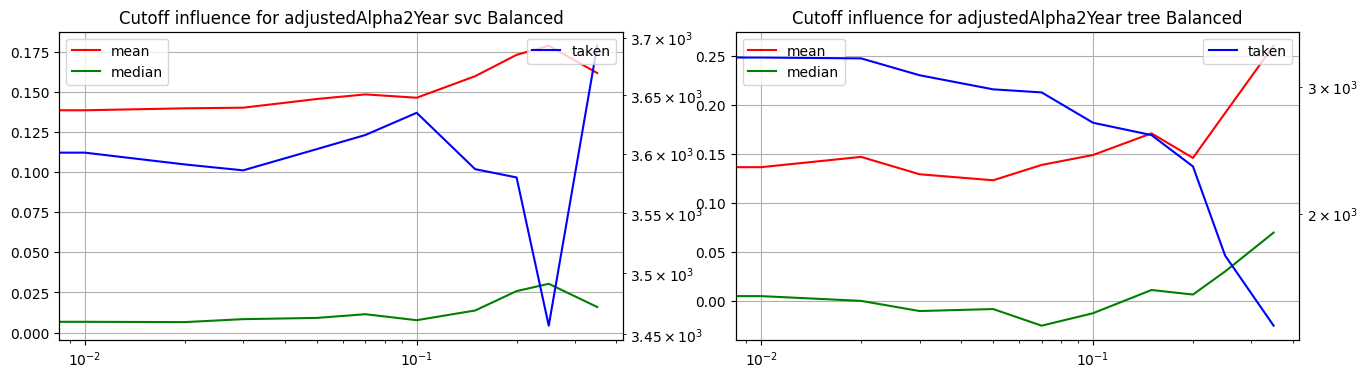

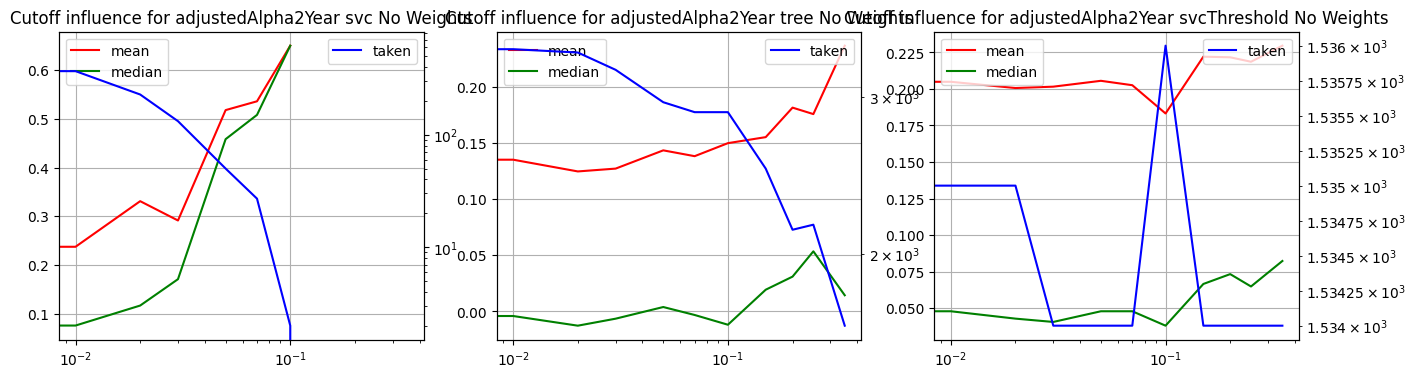

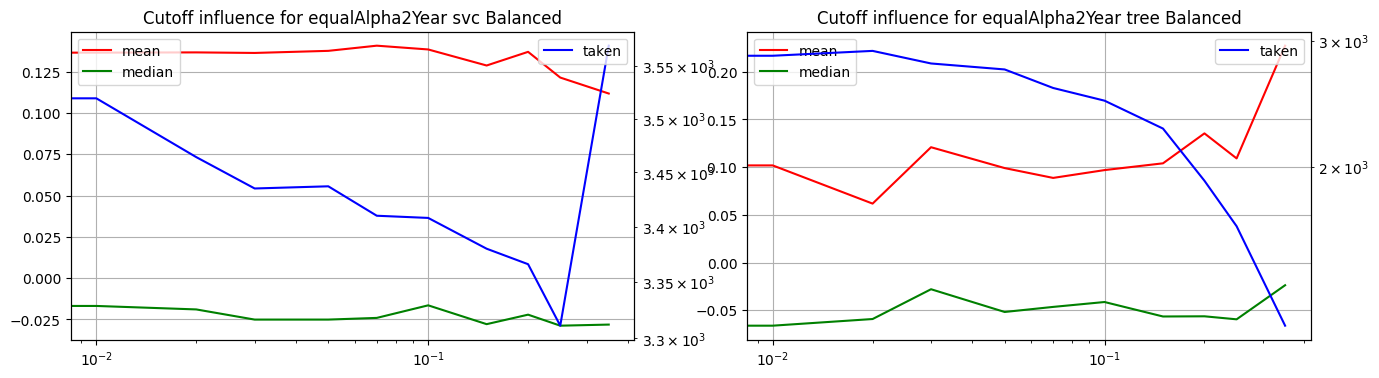

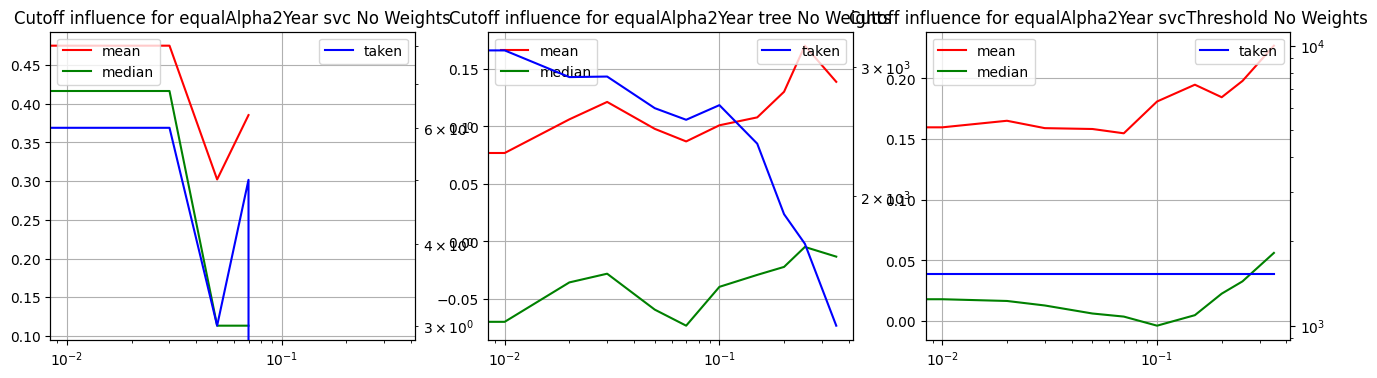

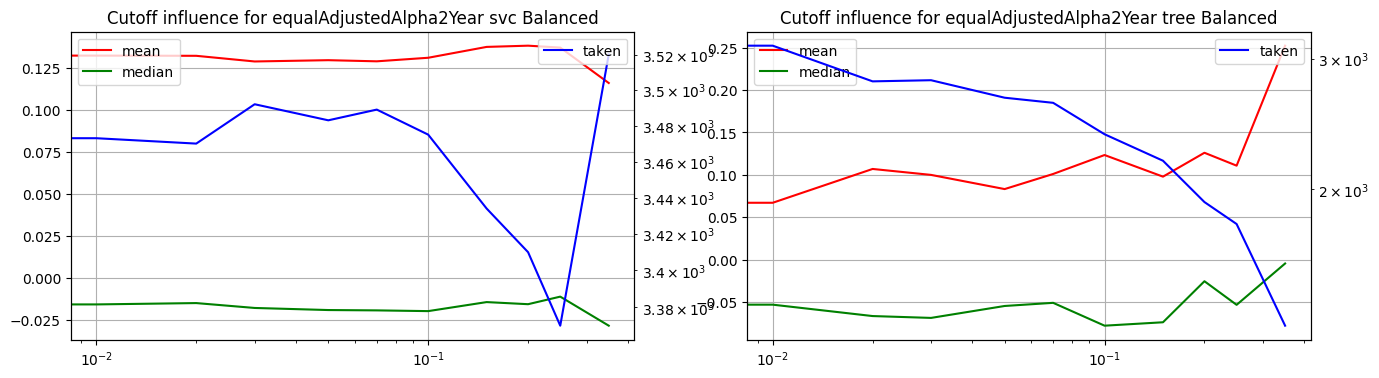

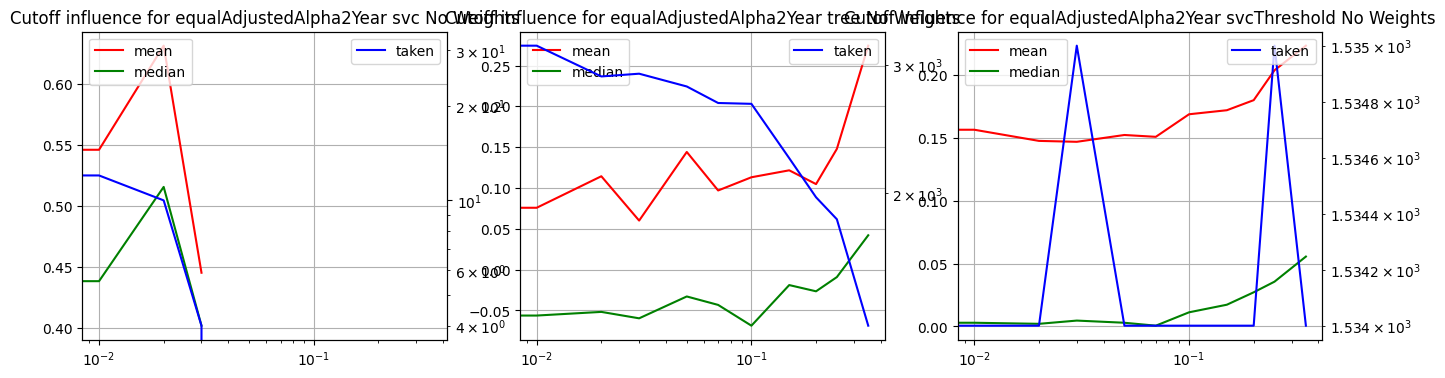

In [28]:
x = cutoffs
for yLabel in resultsToPlot.keys():
    toPlot = resultsToPlot[yLabel]
    toPlotNoWeights = resultsToPlotNoWeights[yLabel]
    
    drawFrom1results(toPlot, yLabel, title='Balanced')

    drawFrom1results(toPlotNoWeights, yLabel, title='No Weights', keys=['svc', 'tree', 'svcThreshold'])
    
    plt.show()